In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - loss: 0.0126
Average validation loss: 0.3773021697998047
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - loss: 0.0126 - val_loss: 0.3773
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step - loss: 0.0083 - val_loss: 0.3773
Average validation loss: 0.36921563744544983
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - loss: 0.0083 - val_loss: 0.3733
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 511ms/step - loss: 0.0059 - val_loss: 0.3733
Average validation loss: 0.4407157301902771
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 522ms/step - loss: 0.0059 - val_loss: 0.3957
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 512ms/step - loss: 0.0046 - val_loss: 0.3957
Average validation loss: 0.31

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 775ms/step - loss: 3.8244e-07
Average validation loss: 0.1354636773467064
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 786ms/step - loss: 3.8244e-07 - val_loss: 0.1355
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 778ms/step - loss: 3.6574e-07 - val_loss: 0.1355
Average validation loss: 0.10210173949599266
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 790ms/step - loss: 3.6574e-07 - val_loss: 0.1188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 776ms/step - loss: 3.6398e-07 - val_loss: 0.1188
Average validation loss: 0.06632447056472301
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 3.6398e-07 - val_loss: 0.1013
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 787ms/step - loss: 1.6982e-07
Average validation loss: 0.03861961017052332
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 797ms/step - loss: 1.6982e-07 - val_loss: 0.0386
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step - loss: 1.6248e-07 - val_loss: 0.0386
Average validation loss: 0.05232217162847519
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 787ms/step - loss: 1.6248e-07 - val_loss: 0.0455
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 778ms/step - loss: 1.5693e-07 - val_loss: 0.0455
Average validation loss: 0.032351947389543056
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 787ms/step - loss: 1.5693e-07 - val_loss: 0.0411
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 773ms/step - loss: 1.5255e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 776ms/step - loss: 1.2012e-07
Average validation loss: 0.04432471143081784
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 785ms/step - loss: 1.2012e-07 - val_loss: 0.0443
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 775ms/step - loss: 1.1609e-07 - val_loss: 0.0443
Average validation loss: 0.0391784287057817
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 783ms/step - loss: 1.1609e-07 - val_loss: 0.0418
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 778ms/step - loss: 1.0757e-07 - val_loss: 0.0418
Average validation loss: 0.049828873947262764
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 1.0757e-07 - val_loss: 0.0444
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 779ms/step - loss: 1.0403e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 778ms/step - loss: 7.1585e-08
Average validation loss: 0.023109626956284046
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 788ms/step - loss: 7.1585e-08 - val_loss: 0.0231
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - loss: 7.2279e-08 - val_loss: 0.0231
Average validation loss: 0.029722755029797553
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 786ms/step - loss: 7.2279e-08 - val_loss: 0.0264
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 777ms/step - loss: 7.3637e-08 - val_loss: 0.0264
Average validation loss: 0.02381578804925084
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 787ms/step - loss: 7.3637e-08 - val_loss: 0.0255
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 776ms/step - loss: 7.1206e-08 - val_loss: 0.0255
Average validation loss: 0.026768275257200002
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 785ms/step - loss: 7.1206e-08 - val_loss: 0.0259
Epoch 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 774ms/step - loss: 1.3326e-07
Average validation loss: 0.019804014824330807
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 783ms/step - loss: 1.3326e-07 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 773ms/step - loss: 1.1949e-07 - val_loss: 0.0198
Average validation loss: 0.024533588128785293
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 783ms/step - loss: 1.1949e-07 - val_loss: 0.0222
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 778ms/step - loss: 1.0627e-07 - val_loss: 0.0222
Average validation loss: 0.019128233349571627
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 1.0627e-07 - val_loss: 0.0212
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 776ms/step - loss: 9.78

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 791ms/step - loss: 1.1421e-07
Average validation loss: 0.04020802178420126
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 800ms/step - loss: 1.1421e-07 - val_loss: 0.0402
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 776ms/step - loss: 1.0723e-07 - val_loss: 0.0402
Average validation loss: 0.0492168833501637
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 784ms/step - loss: 1.0723e-07 - val_loss: 0.0447
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 775ms/step - loss: 1.0668e-07 - val_loss: 0.0447
Average validation loss: 0.04939052071422338
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 783ms/step - loss: 1.0668e-07 - val_loss: 0.0463
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 776ms/step - loss: 9.8344e-08 - val_loss: 0.0463
Average validation loss: 0.05356636275537312
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 785ms/step - loss: 9.8344e-08 - val_loss: 0.0481
Epoch 5/

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 779ms/step - loss: 2.0670e-07
Average validation loss: 0.0212632513527448
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 2.0670e-07 - val_loss: 0.0213
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 775ms/step - loss: 2.0260e-07 - val_loss: 0.0213
Average validation loss: 0.029577471160640318
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 783ms/step - loss: 2.0260e-07 - val_loss: 0.0254
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 773ms/step - loss: 2.1048e-07 - val_loss: 0.0254
Average validation loss: 0.022564770731454093
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 782ms/step - loss: 2.1048e-07 - val_loss: 0.0245
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 150s 776ms/step - loss: 2.1306e-07 - val_loss: 0.0245
Average validation loss: 0.029753750190138817
48/48 ━━━━━━━━━━━━━━━━━━━━ 151s 785ms/step - loss: 2.1306e-07 - val_loss: 0.0258
Epo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 780ms/step - loss: 1.0483e-07
Average validation loss: 0.02593412123886602
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 789ms/step - loss: 1.0483e-07 - val_loss: 0.0259
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 775ms/step - loss: 1.3551e-07 - val_loss: 0.0259
Average validation loss: 0.025489405928445712
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 784ms/step - loss: 1.3551e-07 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 776ms/step - loss: 1.4957e-07 - val_loss: 0.0257
Average validation loss: 0.022005441199455942
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 785ms/step - loss: 1.4957e-07 - val_loss: 0.0245
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 778ms/step - loss: 5.9459e-08
Average validation loss: 0.025511329469736665
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 788ms/step - loss: 5.9459e-08 - val_loss: 0.0255
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 776ms/step - loss: 4.9921e-08 - val_loss: 0.0255
Average validation loss: 0.024204871500842273
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 784ms/step - loss: 4.9921e-08 - val_loss: 0.0249
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 778ms/step - loss: 4.6791e-08 - val_loss: 0.0249
Average validation loss: 0.022188577393535525
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 789ms/step - loss: 4.6791e-08 - val_loss: 0.0240
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - loss: 1.3045e-07
Average validation loss: 0.027791282213810418
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 785ms/step - loss: 1.3045e-07 - val_loss: 0.0278
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 777ms/step - loss: 1.3926e-07 - val_loss: 0.0278
Average validation loss: 0.024601242918935087
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 785ms/step - loss: 1.3926e-07 - val_loss: 0.0262
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 778ms/step - loss: 1.3652e-07 - val_loss: 0.0262
Average validation loss: 0.026898380058507126
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 785ms/step - loss: 1.3652e-07 - val_loss: 0.0264
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 777ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 775ms/step - loss: 5.4181e-08
Average validation loss: 0.02509992988780141
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 783ms/step - loss: 5.4181e-08 - val_loss: 0.0251
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 776ms/step - loss: 5.1742e-08 - val_loss: 0.0251
Average validation loss: 0.023754808050580323
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 784ms/step - loss: 5.1742e-08 - val_loss: 0.0244
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 776ms/step - loss: 4.8975e-08 - val_loss: 0.0244
Average validation loss: 0.023253011633642018
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 786ms/step - loss: 4.8975e-08 - val_loss: 0.0240
Saved model weights to 'c:\天_11157065\git\RipplesDetection\a

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 775ms/step - loss: 3.0203e-07
Average validation loss: 0.029059880199686933
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 784ms/step - loss: 3.0203e-07 - val_loss: 0.0291
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 775ms/step - loss: 2.2842e-07 - val_loss: 0.0291
Average validation loss: 0.022931926146460075
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 783ms/step - loss: 2.2842e-07 - val_loss: 0.0260
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 774ms/step - loss: 1.9631e-07 - val_loss: 0.0260
Average validation loss: 0.022447235086777557
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 785ms/step - loss: 1.9631e-07 - val_loss: 0.0248
Saved model weights to 'c:\天_11157065\git\RipplesDetection\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 777ms/step - loss: 8.3441e-07
Average validation loss: 0.01968718670347395
120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step - loss: 8.3441e-07 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 776ms/step - loss: 5.5681e-07 - val_loss: 0.0197
Average validation loss: 0.011755604048569996
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 788ms/step - loss: 5.5681e-07 - val_loss: 0.0157
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 282s 775ms/step - loss: 4.2092e-07 - val_loss: 0.0157
Average validation loss: 0.008661925129126757
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 782ms/step - loss: 4.2092e-07 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\Ripple

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 776ms/step - loss: 6.8409e-08
Average validation loss: 0.012648942398502387
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 784ms/step - loss: 6.8409e-08 - val_loss: 0.0126
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 775ms/step - loss: 2.0911e-07 - val_loss: 0.0126
Average validation loss: 0.036955814270028337
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 784ms/step - loss: 2.0911e-07 - val_loss: 0.0248
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 337s 773ms/step - loss: 2.9036e-07 - val_loss: 0.0248
Average validation loss: 0.02587188196695125
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 782ms/step - loss: 2.9036e-07 - val_loss: 0.0252
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 450s 773ms/step - loss: 3.0538e-07 - val_loss: 0.0252
Average validation loss: 0.020052859264978906
144/144 ━━━━━━━━━━━━━━━━━━━━ 452s 786ms/step - loss: 3.0538e-07 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 773ms/step - loss: 3.6295e-07
Average validation loss: 0.06300755744117623
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 781ms/step - loss: 3.6295e-07 - val_loss: 0.0630
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 249s 773ms/step - loss: 3.5774e-07 - val_loss: 0.0630
Average validation loss: 0.022634242825188267
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 781ms/step - loss: 3.5774e-07 - val_loss: 0.0428
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 374s 775ms/step - loss: 3.3703e-07 - val_loss: 0.0428
Average validation loss: 0.017017503728857263
160/160 ━━━━━━━━━━━━━━━━━━━━ 375s 783ms/step - loss: 3.3703e-07 - val_loss: 0.0342
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 776ms/step - loss: 1.5758e-07
Average validation loss: 0.01269763621268794
200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 786ms/step - loss: 1.5758e-07 - val_loss: 0.0127
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 774ms/step - loss: 1.2358e-07 - val_loss: 0.0127
Average validation loss: 0.013790464226622135
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 786ms/step - loss: 1.2358e-07 - val_loss: 0.0132
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 469s 774ms/step - loss: 1.0411e-07 - val_loss: 0.0132
Average validation loss: 0.4069127869606018
200/200 ━━━━━━━━━━━━━━━━━━━━ 471s 782ms/step - loss: 1.0411e-07 - val_loss: 0.1445
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 626s 774ms/step - loss: 9.2328e-08 - val_loss: 0.1445
Average validation loss: 0.015973520072438987
200/200 ━━━━━━━━━━━━━━━━━━━━ 627s 782ms/step - loss: 9.2328e-08 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 186s 774ms/step - loss: 6.1603e-08
Average validation loss: 0.020388162586823456
240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 783ms/step - loss: 6.1603e-08 - val_loss: 0.0204
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 374s 774ms/step - loss: 5.4214e-08 - val_loss: 0.0204
Average validation loss: 0.015502038307022303
240/240 ━━━━━━━━━━━━━━━━━━━━ 376s 783ms/step - loss: 5.4214e-08 - val_loss: 0.0179
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 561s 773ms/step - loss: 4.9218e-08 - val_loss: 0.0179
Average validation loss: 0.01516052600054536
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 782ms/step - loss: 4.9218e-08 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\Ripp

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12554914824664593, 0.055892300112172964, 0.031989011829718944, 0.03734203204978257, 0.027454632129520182, 0.020731869191707424, 0.0343241357523948, 0.028329228267539294, 0.027621281194899764, 0.03145867781073321, 0.02905304882158008, 0.025956561840139326, 0.02513702753892479, 0.018744527596498906, 0.025894811540301377, 0.07529824109655772, 0.03846807294641985, 0.017890889435198464]
std_val_losses =  [0.09654046112645638, 0.029370487635164932, 0.01206753128713438, 0.009372756118709089, 0.007892610173358563, 0.003870820668305468, 0.009506621548934833, 0.005340720039789101, 0.003948281838808182, 0.012223478973563795, 0.0115717249277667, 0.004107705234473867, 0.0035656973559449975, 0.006388990312625926, 0.009536216778972694, 0.27040032907545486, 0.06762461799914353, 0.0026839438399410597]


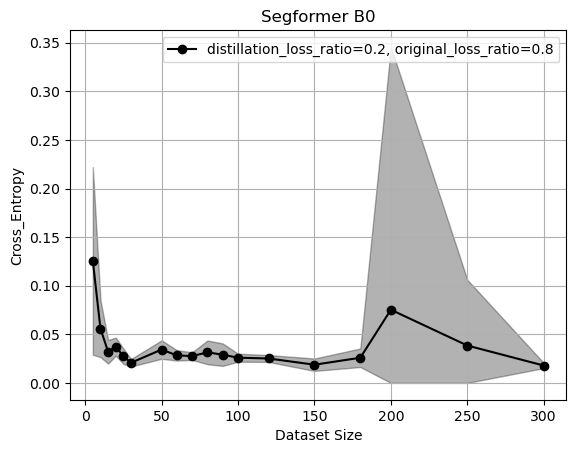

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()